In [2]:
from fase.fileio import Table
import eagleSqlTools as egl
import numpy as np
import  matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})
import time
import pandas as pd

# Query to VIRGO to get the Light-cone

In [3]:
# CONNECTION TO THE VIRGO DATABASE
con = egl.connect(user="giorgio",password='BN401kmd') 

In [8]:
query =  'SELECT LC.UniqueGalaxyID, LC.GalaxyID, LC.redshift_cos, LC.redshift_obs, SS.mag_V, SS.SDSS_u, SS.SDSS_i_obs  '
query += 'FROM DESI_v1..LC_20sqdeg_Gonzalez2014a as LC, DESI_v1..GAL_Gonzalez2014a as SS '
query += 'WHERE LC.GalaxyID=SS.GalaxyID '
query += 'AND LC.redshift_obs < 1.5 '
query += 'AND LC.redshift_obs > 0.4'

In [9]:
t1 = time.time()
LC = egl.execute_query(con,query)
t2 = time.time()
print t2-t1

69.3177928925


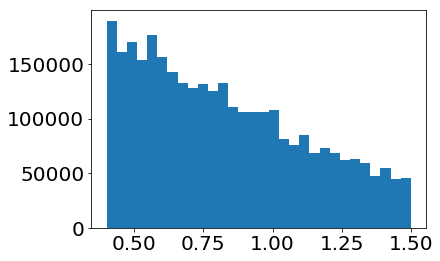

In [14]:
plt.hist(LC['redshift_obs'],bins=30)
plt.show()

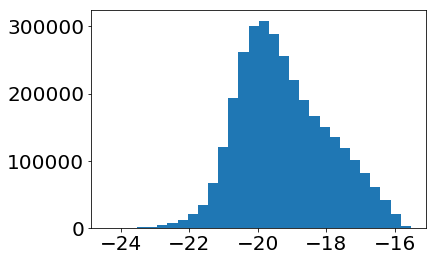

In [15]:
plt.hist(LC['mag_V'],bins=30)
plt.show()

In [16]:
len(LC['mag_V'])

3170254

In [18]:
lightcone = pd.DataFrame(LC)

In [20]:
lightcone.to_csv('../data/lightcone_gonzalez_z04_z15.txt',sep=' ',index=None)

# READ LIGHTCONE FROM MY TXT FILE

In [22]:
lightcone = pd.read_csv('../data/lightcone_gonzalez_z04_z15.txt',sep=' ')

In [30]:
z_obs = np.array(lightcone['redshift_obs'])
v =     np.array(lightcone['mag_V'])
u =     np.array(lightcone['SDSS_u'])
i =     np.array(lightcone['SDSS_i_obs'])

In [31]:
sel_0405 = np.where((z_obs>0.4)&(z_obs<0.5))
sel_1013 = np.where((z_obs>1.0)&(z_obs<1.3))

(array([4.0000e+00, 8.0000e+00, 4.3000e+01, 9.0000e+01, 2.3100e+02,
        4.7300e+02, 1.0100e+03, 1.6950e+03, 2.7060e+03, 4.2450e+03,
        6.1570e+03, 9.4200e+03, 1.5535e+04, 2.6312e+04, 4.2052e+04,
        5.7307e+04, 6.8331e+04, 7.1575e+04, 6.9792e+04, 6.7535e+04,
        6.4404e+04, 5.4098e+04, 3.5021e+04, 1.3848e+04, 2.6390e+03,
        1.9500e+02, 1.5000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-24.413063  , -24.17224293, -23.93142287, -23.6906028 ,
        -23.44978273, -23.20896267, -22.9681426 , -22.72732253,
        -22.48650247, -22.2456824 , -22.00486233, -21.76404227,
        -21.5232222 , -21.28240213, -21.04158207, -20.800762  ,
        -20.55994193, -20.31912187, -20.0783018 , -19.83748173,
        -19.59666167, -19.3558416 , -19.11502153, -18.87420147,
        -18.6333814 , -18.39256133, -18.15174127, -17.9109212 ,
        -17.67010113, -17.42928107, -17.188461  ]),
 <a list of 1 Patch objects>)

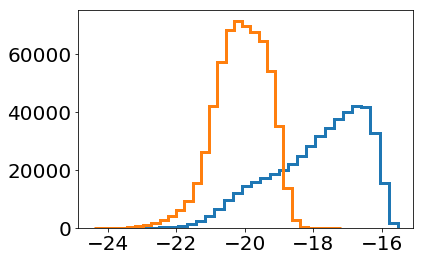

In [37]:
plt.hist(v[sel_0405],bins=30,lw=3,histtype='step')
plt.hist(v[sel_1013],bins=30,lw=3,histtype='step')

In [41]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

In [45]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

In [54]:
def colmag_cut_ALTERNATIVE(v37,
               u37,
               i37,
               v47,
               u47,
               i47,
               title='Giorgio AGN',
               path_fig='./plots/snap.png',
               save_fig=False,
               xbsz=0.1,
               ybsz=0.05,
               thr=0.15,
               fix_point=False,
               Npoints37=100,
               Npoints47=100,
               N_colour_bins=15,
               contours=True):

    plt.figure(figsize=(14,12))
    plt.ylim(-0.5,2.5)
    plt.xlim(-30,-5)

    # snapshot 37 (z=1.17)
    sec37= np.where(i37<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=1.1734))

    plt.plot(v37[sec37],u37[sec37]-v37[sec37],".",alpha=0.9,zorder=1,color='C1',markersize=1.3)
    #plt.hist2d(v37[sec37],u37[sec37]-v37[sec37],bins=60)
    
    
    if (fix_point==False):
        e37_x,e37_y = EDGE(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)
    else:
        print("z =1.17")
        e37_x,e37_y = EDGE_fixed_Npoints(v37[sec37],u37[sec37]-v37[sec37],y_min=0.6,y_points_per_bin=Npoints37,x_max=-15,x_bin_size=xbsz,threashold=thr,y_Nbins=N_colour_bins)
    
    plt.plot(e37_x,e37_y,lw=4,color='darkorange')
    plt.plot(e37_x,e37_y,".",markersize=15,color='darkorange',label='1.0 < z < 1.3')

    if contours:
        h37_c, h37_bx, h37_by = np.histogram2d(v37[sec37],u37[sec37]-v37[sec37],bins=10)
        plt.contour(h37_bx[:-1],h37_by[:-1],h37_c.T)
        plt.colorbar(label='z = 1.17')
    

    # snapshot 47 (z=0.46)
    sec47 = np.where(i47<ABSOLUTE_MAGNITUDE_minus5logh(22.5,z=0.456))
    plt.plot(v47[sec47],u47[sec47]-v47[sec47],".",alpha=0.3,zorder=-1,color='C0',markersize=1.)
    #plt.hist2d(v47[sec47],u47[sec47]-v47[sec47],bins=100)
    
    if (fix_point==False):
        e47_x,e47_y = EDGE(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_bin_size=ybsz,x_max=-15,x_bin_size=xbsz,threashold=thr)
    else:
        print("z =0.46")
        e47_x,e47_y = EDGE_fixed_Npoints(v47[sec47],u47[sec47]-v47[sec47],y_min=0.6,y_points_per_bin=Npoints47,x_max=-15,x_bin_size=xbsz,threashold=thr,y_Nbins=N_colour_bins)
    
    plt.plot(e47_x,e47_y,lw=4,color='blue')
    plt.plot(e47_x,e47_y,".",markersize=15,color='blue',label='0.4 < z < 0.5')

    #contours
    if contours:
        h47_c, h47_bx, h47_by = np.histogram2d(v47[sec47],u47[sec47]-v47[sec47],bins=100)
        plt.contour(h47_bx[:-1],h47_by[:-1],h47_c.T)
        plt.colorbar(label='z = 0.46',orientation='horizontal')
    
    plt.xlabel("mag_V_ext")
    plt.ylabel("SDSS_U_ext - mag_V_ext")
    if (fix_point==False):
        plt.title(title)
    else:
        plt.title(title+" (fixed point)")

    plt.xlim(-26.,-17.)
    plt.ylim(0.,2.3)

    plt.legend()
    if save_fig:
        plt.savefig(path_fig)
    plt.show()

In [43]:
def EDGE_fixed_Npoints(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_Nbins=15,y_points_per_bin=400,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    print('Computing...')
    print('colour_bin \t bin_size')
    #y_Nbins = int((y_max - y_min) / y_bin_size)
    
    y_bin_step = float((y_max - y_min) / y_Nbins)
    
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    
    #loop on y bins
    for i in range(y_Nbins):
        y_center  = y_min + y_bin_step * i
        # define the y bin which contains at least y_points_per bin
        
        select_y_in_ybin = [[]]
        y_epsilon= 0.000
        while (len(select_y_in_ybin[0])<y_points_per_bin): 
            y_epsilon = y_epsilon + 0.005
            y_low = y_center-y_epsilon
            y_high = y_center+y_epsilon
        
            select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        print(round(y_center,2),"\t",y_epsilon*2)      
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    print('...done.')
    return np.array(x_edge), np.array(y_edge)

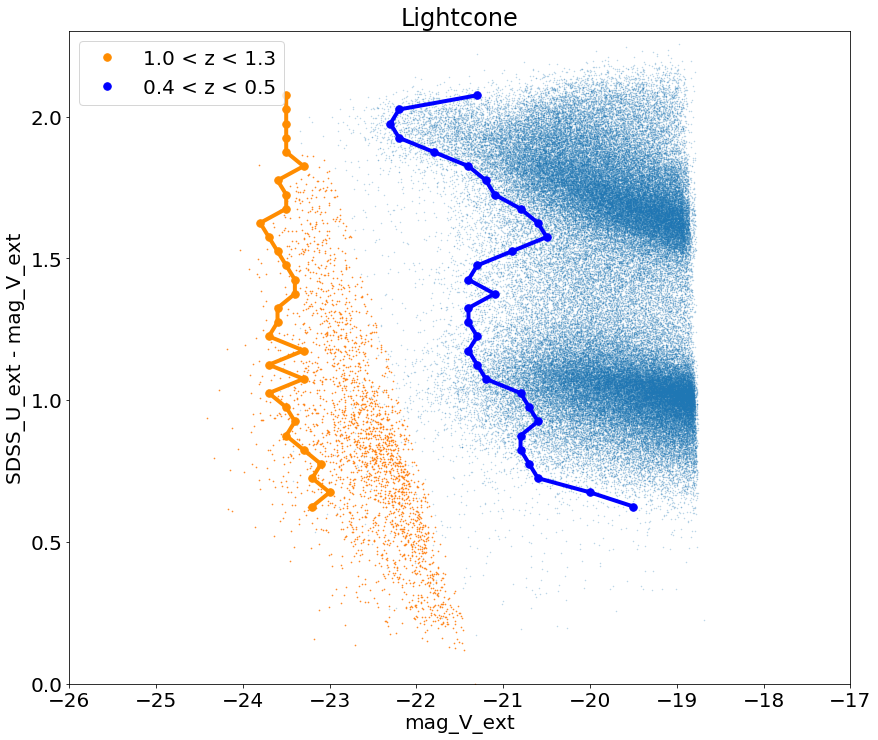

In [58]:
colmag_cut_ALTERNATIVE(v37= v[sel_1013],
               u37=u[sel_1013],
               i37=i[sel_1013],
               v47=v[sel_0405],
               u47=u[sel_0405],
               i47=i[sel_0405],
               title='Lightcone',
               path_fig='../plots/013/lightcone.png',
               save_fig=True,
               xbsz=0.1,
               ybsz=0.05,
               thr=0.15,
               fix_point=False,
               Npoints37=100,
               Npoints47=100,
               N_colour_bins=15,
               contours=False)